# MVP Engenharia de Dados - PUC rio

**Aluno:** Carlos Roberto Batista Rocha Júnior

Julho de 2024

# Projeto de dados - Co2 Emission

**Objetivo**

Esse projeto tem como objetivo de criar uma análise exploratória do um dataset "CO2 Emission by countries Year wise (1750-2022)" que reúne os níveis de emissão de CO2 entre 1750 e 2022. Com isso, busco entender como o comportamento de emissão de CO2 está relacionada à evolução do processo industrial ao longo dos anos em alguns países selecionados. 

# 1. Definição do problema

O Dataset utilizado nesse projeto é o "CO2 Emission by countries Year wise (1750-2022)" disponível no Kaggle no link abaixo.
https://www.kaggle.com/datasets/moazzimalibhatti/co2-emission-by-countries-year-wise-17502022

Esse dataset reúne 9 atributos com informações de emissão de CO2 oriundos de 220 países entre os anos 1750 e 2022.

**Informações sobre os atributos**

  1.   Country - nome do país
  2.   Code - Código do país com duas letras
  3.   Calling Code - código de telefone do país
  4.   Year - ano da emissão
  5.   CO2 emission (tons) - CO2 emitido em toneladas
  6.   Population (2022) - número de pessoas em 2022
  7.   Area - Área do país em km2
  8.   %of word - A porcentagem de emissão que cada país é responsável
  9.   Density(Km2) - densidade de acordo com área em km2

## 1.1 - Contextualização 


Como exposto, o objetivo desse trabalho é construir uma análise exploratória de dados do dataset descrito acima. No entanto, como parte do projeto de avaliação da sprint, iremos iniciar esse notebook a partir da estruturação e coleta da base dados, inicialmente feita na plataforma Databricks.
Portanto, esse notebook será dividido em 3 partes:

  1.   Coleta e modelagem de dados
  2.   Tratamento de dados
  3.   Análise de dados e Estudos de caso


# 2. Coleta e modelagem de dados

Nessa etapa, discutiremos o dataset selecionado, sua forma de coleta e armazenamento. Para isso, usaremos a plataforma Databricks para realizar todo o processo de ETL.


## 2.1 - Coleta de dados

O dataset é composto pelos atributos descritos acima. Além disso, a tabela abaixo retirada do Databricks, resume seu tipo de dados. Com ele, já seremos capazes de observar que existem necessidades de transformação de dados, como nos atributos % of World e Desinty (km2), que serão exploradas nas próximas etapas.

| Col_name    | Data_type |   Comment   |
|----------  |---------- |----------|
|Country | Object | null |
|Code | Object | null |
|Calling Code | Object | null |
|Year | Object | null |
|CO2 emission (Tons) | Object | null |
|Population(2022) | Object | null |
|Area | Object| null |
|% of World | Object | null |
|Density(km2) | Object |  null  |

## 2.2 - Esquema de dados

Entendendo que o principal objetivo do trabalho é uma análise de dados do conjunto proposto, utilizaremos uma abordagem ROLAP para construção do Data warehouse (DW), uma vez que essa permite um armazenamento de dados em tabelas relacionais, mas otimizado para consutlas analíticas. 
Para isso, para esse conjunto de dados, utilizaremos o esquema Estrela, em que existe uma tabela de fato central com todos os dados brutos e chaves estrangeiras descritas em tabelas de Dimensão. 
Sendo assim, a imagem abaixo resume a construção desse banco. 

**CO2 Fact Table**

  * Country_key
  * Year
  * CO2_emission_Tons
-----------------------------
**Country Dimension Table**
  * Country_key
  * Country
  * Code
  * Calling_Code
  * Area
  * Population_2022
  * % of World
  * Density(Km2)
-------------------------------------------------------------------------------------------------
**Relação Entre as Tabelas**

A tabela CO2 Fact está relacionada à tabela Country Dimension através da coluna Country_key.

A partir da imagem acima, podemos identificar que o esquema de dados proposto é dado pela tabela de fato, que reúne as informações de emissão de CO2 por país e por ano, e pela tabela de dimensões, que reúne informações de cada país. Logo, esse esquema é o caminho mais curto para navegação no banco de dados.

## 2.3 Carga de dados

O bloco de código abaixo usa o pacote spark para carregar o dataset nesse notebook e exibe as primeiras linhas. Além disso, o segundo bloco de código exibe as características desse dataframe.

In [0]:
# File location and type
file_location = "/FileStore/tables/CO2_emission_by_countries-5.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

# Limitar a exibição às primeiras 10 linhas
df_limited = df.limit(10)

# Exibir as primeiras 10 linhas do DataFrame
display(df_limited)

Country,Code,Calling Code,Year,CO2 emission (Tons),Population(2022),Area,% of World,Density(km2)
Afghanistan,AF,93,1750,0,41128771,652230,0.40%,63/km�
Afghanistan,AF,93,1751,0,41128771,652230,0.40%,63/km�
Afghanistan,AF,93,1752,0,41128771,652230,0.40%,63/km�
Afghanistan,AF,93,1753,0,41128771,652230,0.40%,63/km�
Afghanistan,AF,93,1754,0,41128771,652230,0.40%,63/km�
Afghanistan,AF,93,1755,0,41128771,652230,0.40%,63/km�
Afghanistan,AF,93,1756,0,41128771,652230,0.40%,63/km�
Afghanistan,AF,93,1757,0,41128771,652230,0.40%,63/km�
Afghanistan,AF,93,1758,0,41128771,652230,0.40%,63/km�
Afghanistan,AF,93,1759,0,41128771,652230,0.40%,63/km�


In [0]:
# Mostrar o schema do DataFrame
df.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Code: string (nullable = true)
 |-- Calling Code: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- CO2 emission (Tons): string (nullable = true)
 |-- Population(2022): string (nullable = true)
 |-- Area: string (nullable = true)
 |-- % of World: string (nullable = true)
 |-- Density(km2): string (nullable = true)



# 3. Tratamento de dados

Uma vez carregado o dataset, vamos entender quais são suas características de construção, como sua dimensão e informações. Para isso, o código abaixo importa todos os pacotes necessários.

In [0]:
# Importação de pacotes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler # normalização
from sklearn.preprocessing import StandardScaler # padronização
from sklearn.preprocessing import OrdinalEncoder # ordinal encoding
from sklearn.preprocessing import OneHotEncoder # one-hot encoding e dummy encoding

# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

In [0]:
# Mostrar as dimensões do DataFrame 
print((df.count(), len(df.columns)))

(59620, 9)


In [0]:
# Resumo estatístico básico de colunas numéricas
df.describe().show()

+-------+-----------+-----+------------------+-----------------+--------------------+--------------------+------------------+----------+------------+
|summary|    Country| Code|      Calling Code|             Year| CO2 emission (Tons)|    Population(2022)|              Area|% of World|Density(km2)|
+-------+-----------+-----+------------------+-----------------+--------------------+--------------------+------------------+----------+------------+
|  count|      59620|57723|             56097|            59620|               59620|               53116|             55284|     55284|       53116|
|   mean|       null| null|388.64921465968587|           1885.0|1.0347736947399698E9|3.9922597596938774E7| 652207.3039215687|      null|        null|
| stddev|       null| null|306.82377977466575|78.23108494606949|1.041651778353645...|1.4823648448336864E8|1865482.5780209186|      null|        null|
|    min|Afghanistan|   AD|                 1|             1750|                   0|            101

Os códigos acima revelam que o dataset é composto pelos 9 atributos já descritos e 59.620 linhas formado por números e textos. Além disso, podemos observar que existem alguns atributos com valor nulo, entre eles, os atributos Code e Calling Code, no entanto, nesse caso, não há problema pois são formas de identificação do país já representada pelo seu nome. Além disso, vale observar que os atributos ano e CO2 emission estão completos.

Agora, o código abaixo busca entender como os dados estão distribuídos por ano e por país. Com eles, vamos observar que não há problemas de distribuição de informação em nenhum desses atributos.

In [0]:
# Importar funções do Spark SQL
from pyspark.sql.functions import col

# Agrupar e contar o número de ocorrências de cada país
count_by_country = df.groupBy('Country').count().orderBy('count', ascending=False)

# Exibir os resultados
count_by_country.show()


+-----------+-----+
|    Country|count|
+-----------+-----+
|       Chad|  271|
|   Anguilla|  271|
|   Paraguay|  271|
|     Russia|  271|
|      Macao|  271|
|      Yemen|  271|
|    Senegal|  271|
|     Sweden|  271|
|   Kiribati|  271|
|     Guyana|  271|
|    Eritrea|  271|
|Philippines|  271|
|   Djibouti|  271|
|      Tonga|  271|
|   Malaysia|  271|
|  Singapore|  271|
|       Fiji|  271|
|     Turkey|  271|
|     Malawi|  271|
|       Iraq|  271|
+-----------+-----+
only showing top 20 rows



In [0]:
# Agrupar e contar o número de ocorrências de cada ano
count_by_year = df.groupBy('Year').count().orderBy('Year')

# Exibir os resultados
count_by_year.show()


+----+-----+
|Year|count|
+----+-----+
|1750|  220|
|1751|  220|
|1752|  220|
|1753|  220|
|1754|  220|
|1755|  220|
|1756|  220|
|1757|  220|
|1758|  220|
|1759|  220|
|1760|  220|
|1761|  220|
|1762|  220|
|1763|  220|
|1764|  220|
|1765|  220|
|1766|  220|
|1767|  220|
|1768|  220|
|1769|  220|
+----+-----+
only showing top 20 rows



## 3.1 - tratamento de Nulls 

Agora, com o objetivo de melhor entender os insights gerados pelos dados, vamos iniciar o tratamento da base de dados antes de inciarmos as análises de dados. Para isso, o código abaixo verifica se existe valores nulos no dataset original.

In [0]:
# Importar funções do Spark SQL
from pyspark.sql.functions import col, sum as spark_sum

# Contagem de valores nulos para cada coluna
null_counts = df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Exibir os resultados
null_counts.show()

+-------+----+------------+----+-------------------+----------------+----+----------+------------+
|Country|Code|Calling Code|Year|CO2 emission (Tons)|Population(2022)|Area|% of World|Density(km2)|
+-------+----+------------+----+-------------------+----------------+----+----------+------------+
|      0|1897|        3523|   0|                  0|            6504|4336|      4336|        6504|
+-------+----+------------+----+-------------------+----------------+----+----------+------------+



A partir da análise de nulos do dataset, podemos concluir que as variáveis principais de análise (CO2 e Year) não possuem problema. No entanto, algumas outras não deveriam ter valores nulos, como os atribuitos Area, % of World, Density, Population, code e calling code. Para cada uma delas, teremos tratamentos diferentes, como exposto abaixo:

1. Code e Calling Code - levando em consideração que esses dois atributos apenas existem para identificar o país que já está identificado no atributo 'Country', iremos excluí-lo do modelo.

2. Atributos Population, Area, %of world e density(km2) serão substituítos pela mediana de cada atritubto.
    


Para começar, iremos transformar o dataframe spark em um dataframe pandas e converteremos os atributos object em int ou float, quando necessário.

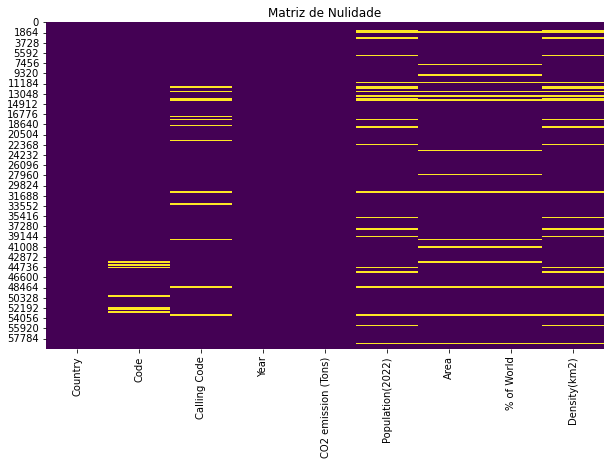

In [0]:
# Converter o DataFrame Spark para um DataFrame Pandas para visualização matricial
df_ml_pandas = df.toPandas()

# Importar a biblioteca matplotlib.pyplot
import matplotlib.pyplot as plt
import seaborn as sns

# Plotar a matriz de nulidade com seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(df_ml_pandas.isnull(), cbar=False, cmap='viridis')
plt.title('Matriz de Nulidade')
plt.show()


In [0]:
# Criando novo dataset para tratamento de missings com todas as colunas
col = list(df_ml_pandas.columns)

# o novo dataset irá conter todas as colunas
DatasetVM = df_ml_pandas[col[:]]

In [0]:
# Mostra as informações do dataset
DatasetVM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59620 entries, 0 to 59619
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Country              59620 non-null  object
 1   Code                 57723 non-null  object
 2   Calling Code         56097 non-null  object
 3   Year                 59620 non-null  object
 4   CO2 emission (Tons)  59620 non-null  object
 5   Population(2022)     53116 non-null  object
 6   Area                 55284 non-null  object
 7   % of World           55284 non-null  object
 8   Density(km2)         53116 non-null  object
dtypes: object(9)
memory usage: 4.1+ MB


In [0]:
# Iniciando a transformação dos atributos Year, Co2 emission, Population e Area

DatasetVM['Year'] = DatasetVM['Year'].astype(int)
DatasetVM['CO2 emission (Tons)'] = DatasetVM['CO2 emission (Tons)'].astype(float)
DatasetVM['Population(2022)'] = DatasetVM['Population(2022)'].astype(float)
DatasetVM['Area'] = DatasetVM['Area'].astype(float)


#Transformando os dados com caracteres especiais
DatasetVM["% of World"] = DatasetVM["% of World"].str.replace('%','', regex=True)
DatasetVM['% of World'] = DatasetVM['% of World'].astype(float)

DatasetVM["Density(km2)"] = DatasetVM["Density(km2)"].str.replace('km²','', regex=True)
DatasetVM["Density(km2)"] = DatasetVM["Density(km2)"].str.replace('km�','', regex=True)
DatasetVM["Density(km2)"] = DatasetVM["Density(km2)"].str.replace('/','', regex=True)
DatasetVM["Density(km2)"] = DatasetVM["Density(km2)"].str.replace(',','.', regex=True)
DatasetVM['Density(km2)'] = DatasetVM['Density(km2)'].astype(float)

In [0]:
# Exbindo as primeiras linhas do novo DatasetVM

DatasetVM.head(10)

,Country,Code,Calling Code,Year,CO2 emission (Tons),Population(2022),Area,% of World,Density(km2)
0,Afghanistan,AF,93,1750,0.0,41128771.0,652230.0,0.4,63.0
1,Afghanistan,AF,93,1751,0.0,41128771.0,652230.0,0.4,63.0
2,Afghanistan,AF,93,1752,0.0,41128771.0,652230.0,0.4,63.0
3,Afghanistan,AF,93,1753,0.0,41128771.0,652230.0,0.4,63.0
4,Afghanistan,AF,93,1754,0.0,41128771.0,652230.0,0.4,63.0
5,Afghanistan,AF,93,1755,0.0,41128771.0,652230.0,0.4,63.0
6,Afghanistan,AF,93,1756,0.0,41128771.0,652230.0,0.4,63.0
7,Afghanistan,AF,93,1757,0.0,41128771.0,652230.0,0.4,63.0
8,Afghanistan,AF,93,1758,0.0,41128771.0,652230.0,0.4,63.0
9,Afghanistan,AF,93,1759,0.0,41128771.0,652230.0,0.4,63.0


Agora, iremos iniciar a limpeza de dados seguindo o que foi dito logo acima. 

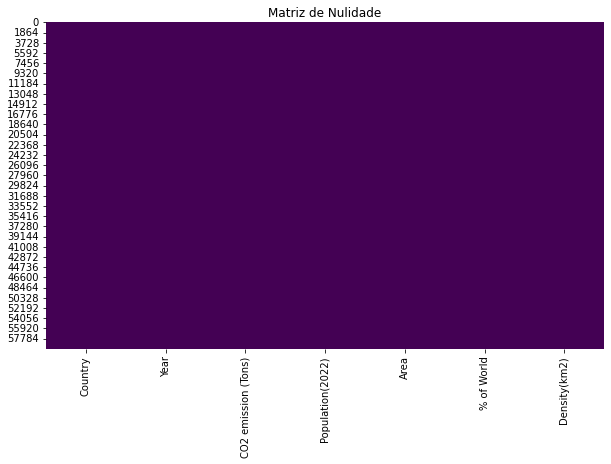

In [0]:
# removendo as colunas 'Code' e 'Calling Code'
DatasetVM.drop(['Code', 'Calling Code'], axis=1, inplace= True)

# substituindo os NaN pela mediana da coluna
DatasetVM['Population(2022)'].fillna(DatasetVM['Population(2022)'].median(), inplace=True)
DatasetVM['Area'].fillna(DatasetVM['Area'].median(), inplace=True)
DatasetVM['Density(km2)'].fillna(DatasetVM['Density(km2)'].median(), inplace=True)

# substituindo os NaN de '%of world' por 0
DatasetVM['% of World'].fillna(0, inplace=True)

# Plotar a matriz de nulidade com seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(DatasetVM.isnull(), cbar=False, cmap='viridis')
plt.title('Matriz de Nulidade')
plt.show()


Assim sendo, o dataset construído acima não possui nenhum valor nulo. Com isso, o próximo passo é inciarmos a análise exploratória de dados visando responder as perguntas objetivo desse trabalho.

# 4. Análise de dados

Esta etapa se dedica a entender como o comportamento de emissão de CO2 está relacionada à evolução do processo industrial ao longo dos anos em alguns países selecionados. Para isso, dividiremos a análise em três partes distintas:

1. Análise estatística
2. Análise multimodais
3. Visualização de dados
4. Análise de componentes principais (PCA)

## 4.1 - Análise estatística
O bloco de código abaixo exibe as estatísticas descritivas do dataset.

In [0]:
# Obtendo as estatísticas descritivas
DatasetVM.describe()

,Year,CO2 emission (Tons),Population(2022),Area,% of World,Density(km2)
count,59620.000000,5.962000e+04,5.962000e+04,5.962000e+04,59620.000000,59620.000000
mean,1885.000000,1.034774e+09,3.651356e+07,6.128018e+05,0.385455,132.821441
std,78.231085,1.041652e+10,1.402560e+08,1.801868e+06,1.162596,151.266644
min,1750.000000,0.000000e+00,1.131200e+04,2.100000e+01,0.000000,0.000000
25%,1817.000000,0.000000e+00,2.522507e+06,2.064575e+04,0.000000,31.750000
50%,1885.000000,0.000000e+00,8.673095e+06,1.103815e+05,0.100000,82.000000
75%,1953.000000,8.715092e+06,2.297867e+07,4.481238e+05,0.300000,163.250000
max,2020.000000,4.170000e+11,1.425887e+09,1.709824e+07,11.000000,872.000000


A análise estatistica descritva do dataset, em primeiro momento, parece não ser muito relevante para o objetivo final desse projeto. Por isso, iremos dividir o dataset em países para obter melhores insights. 
O códgio abaixo cria as médias de emissão de CO2 por país. Com ele, poderemos observar que o país que mais emitiu CO2 ao longo dos anos foram os Estados Unidos.

In [0]:
# Calcular a média de CO2 emitido por país
media_co2_por_pais = DatasetVM.groupby('Country')['CO2 emission (Tons)'].mean().reset_index()

# Renomear as colunas para melhor compreensão
media_co2_por_pais.columns = ['Country', 'Average CO2 Emission (Tons)']

# Ordenar do maior para o menor com base na média de CO2 emitido
media_co2_por_pais = media_co2_por_pais.sort_values(by='Average CO2 Emission (Tons)', ascending=False)

# Exibir o resultado
print(media_co2_por_pais)

               Country  Average CO2 Emission (Tons)
210      United States                 7.036446e+10
209     United Kingdom                 2.273831e+10
74             Germany                 1.955915e+10
39               China                 1.536124e+10
163             Russia                 1.505808e+10
..                 ...                          ...
165       Saint Helena                 2.547829e+04
144               Niue                 2.342095e+04
216  Wallis and Futuna                 1.953218e+04
205             Tuvalu                 1.644321e+04
6           Antarctica                 1.418279e+04

[220 rows x 2 columns]


Além da conclusão acima, agrupar o dataset conforme feito acima também é a base do corte na base de dados para realizar as análises proposta. Sendo assim, iremos concentrar a visualização de dados e suas análises, considerando um dataset composto pelo top 5 países que mais emitiram CO2 em médio e o Brasil. 

## 4.2 Visualizações multimodais

A análise das visualizações multimodais permite entender como os atributos interagem entre si. Para isso, iremos verificar a covariância entre as variáveis númericas do dataset a partir do coeficiente de correlação de Pearson atráves da matriz de correlação, que segue a seguinte lógica:


*   Próximo de -1 - Há uma correlação negativa entre as variáveis;
*   Próximo a +1 - Existe uma correlçaõ positiva entre as variáveis;
*   0: Não existe correlação entre as variávies.

In [0]:
# Criando novo dataset para visualização multimodal com todas as colunas
col = list(DatasetVM.columns)

# o novo dataset irá conter todas as colunas
DatasetMatriz = DatasetVM[col[:]]

# Removendo os atributos 'Country' 
DatasetMatriz.drop(['Country'], axis=1, inplace= True)

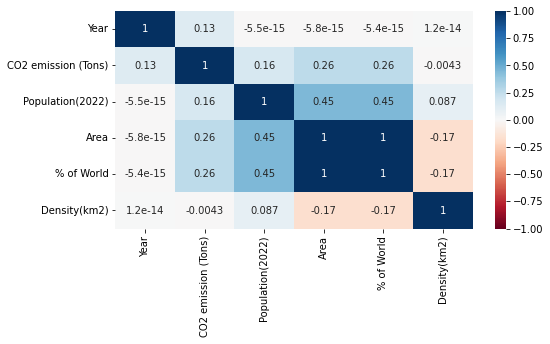

In [0]:
# Matriz de Correlação com Seaborn
plt.figure(figsize = (8,4))
sns.heatmap(DatasetMatriz.corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1);

A primeira vista, podemos observar que o nível de emissão de CO2 em toneladas não tem grandes correlações com as demais variáveis. No entanto, os atributos % of world, Area, Population(2022) são os que melhor explicam as variações na variável de interesse desse estudo.

## 4.3 - Análise de componentes principais (PCA)

A análise de componentes principais é uma técnica da estatística multivariada que consiste em transformar um conjunto de variáveis originais em outro conjunto de variáveis de mesma dimensão denominadas de componentes principais.

In [0]:
#Importando os pacotes necessários

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Variância explicada pelos componentes principais: [0.46567273 0.21283551]


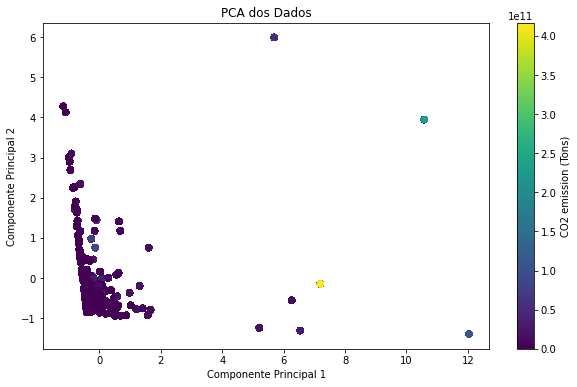

In [0]:
# Separando as variáveis explicativas (X) e a variável explicada (y)
X = DatasetVM[['Year', 'Population(2022)', 'Area', '% of World', 'Density(km2)']]
y = DatasetVM['CO2 emission (Tons)']

# Padronizando as variáveis explicativas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicando PCA
pca = PCA(n_components=2)  # número de componentes principais que você deseja
X_pca = pca.fit_transform(X_scaled)

# Criando um DataFrame com os componentes principais
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

# Adicionando a variável explicada ao DataFrame de PCA
df_pca['CO2 emission (Tons)'] = y.values

# Visualizando a variância explicada pelos componentes principais
explained_variance = pca.explained_variance_ratio_
print(f'Variância explicada pelos componentes principais: {explained_variance}')

# Plotando os componentes principais
plt.figure(figsize=(10, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['CO2 emission (Tons)'], cmap='viridis')
plt.colorbar(label='CO2 emission (Tons)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA dos Dados')
plt.show()

**Interpretação**

Sobre as cores dos pontos nos gráficos:
*  A cor dos pontos representa o nível de CO2 emitido. O gradiente de cores varia do roxo (valores mais baixos) ao amarelo (valores mais altos).

Com isso, podemos observar que os pontos em que existem agrupamentos, todos são da mesma cor, predominantemente. Ou seja, estão associados à níveis de emissão semelhantes. Portanto, quando o nível de emissão de CO2 era mais baixo, essas variáveis eram suficientes para explicar sua variação. Já em níveis de emissão maiores, outras variáveis que não estão aqui pode explicar melhor, como a evolução populacional ao longo dos anos, PIB e etc. 

De outro modo, a variação explicada mostra o quanto um componente principal explica a vairação total dos dados. Sendo assim, podemos observar que os dois componente explicam cerca de 68% das variações do nível de CO2, corroborando com a conclusão acima. 

## 4.4 - Visualizações de dados

Nessa etapa, meu principal objetivo é criar algumas visualizações de dados que nos ajudarão a entender o comportamento do dataset.
Sendo assim, o bloco de código abaixo cria um gráfico de linha do número de CO2 emitido ao longo dos anos.

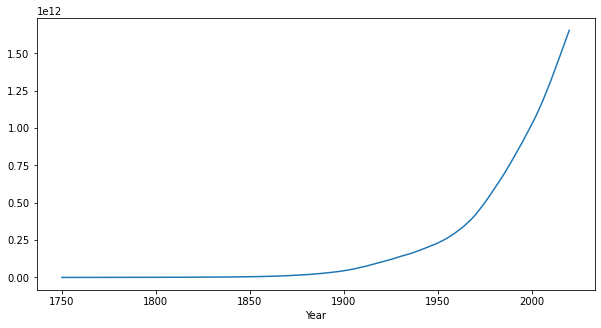

In [0]:
DatasetVM.groupby('Year')['CO2 emission (Tons)'].sum().plot(figsize=(10,5));

O bloco de código abaixo, por sua vez, ilustrra os países que mais emitiram CO2 ao longo do tempo. 

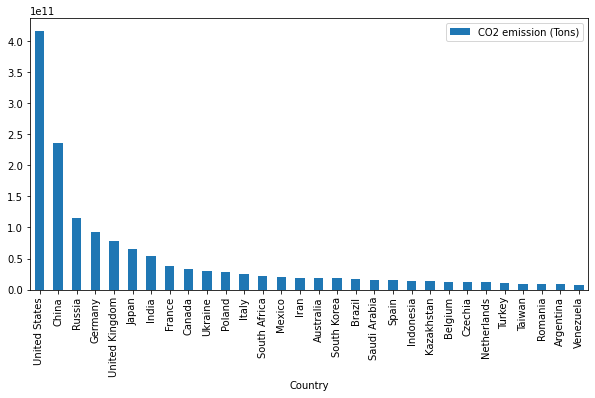

In [0]:
DatasetVM[DatasetVM['Year']==2020].sort_values(by='CO2 emission (Tons)', ascending=False).head(30).plot.bar(x='Country',y='CO2 emission (Tons)',figsize=(10,5));

O primeiro gráfico ilustra a evolução do acumulado da emissão de carbono (Co2 emission (ton)) em toneladas ao longo dos anos. Com ele, podemos observar que o nível de CO2 emitido no ano teve um aumento exponencial a partir de 1900. Ainda, pesquisas indicam que, a partir de 1970, a emissão de Co2 aumentou cerca de 90%.

Já o segundo gráfico, no entanto, ordenam os países por quantidade de emissão de Co2 acumulado. Com ele, podemos observar que Estados Unidos, China, Rússia, Alemanha e Inglaterra são as principais fontes de emissão de Co2.

Por fim, os dados também contam que, apenas em 2020, os top 5 países emissores de CO2 representaram, juntos, 57% da emissão total da base. Por sua vez, juntos, representam cerca de 26% da população. 


Para completar a análise, criarei um novo dataset separando os Top 5 países que mais emitiram CO2 nesse período, além do Brasil. O Bloco de código abaixo cria esse recorte no Dataset e o próximo indica a evoluçãoo de emissão de CO2 desses países ao longo dos anos.

In [0]:
df_top5=DatasetVM[(DatasetVM['Country']=='United States')|
                  (DatasetVM['Country']=='China')|
                  (DatasetVM['Country']=='Russia')|
                  (DatasetVM['Country']=='Germany')|
                  (DatasetVM['Country']=='United Kingdom')|
                  (DatasetVM['Country']== 'Brazil')]

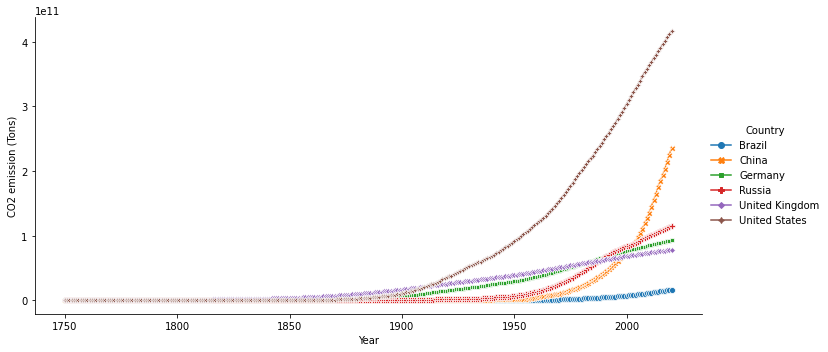

In [0]:
ax=sns.relplot(x="Year", y="CO2 emission (Tons)",
            data=df_top5, kind="line",
            hue="Country", style="Country",
            markers=True, dashes=False,height=5, aspect=2)

O gráfico acima mostra a evolução da emissão de carbono dos top 5 países ao longo do tempo e do Brasil. Com isso, podemos observar que, de maneira geral, o gráfico mostra que a emissão de Co2 era liderado pela Inglaterra até os 1900s. Após esse período, o nível de emissão de Co2 do EUA tiveram um aumento exponencial. Por outro lado, a China teve um aumento exponencial no seu nível de emissão de Co2 a partir dos anos 1950s, mas alcança a segunda colocação a partir de 2010.

Para o Brasil, o nível de emissão apresenta o mesmo comportamento, no entanto, o aumento exponencial teve um atraso, indicando que esse teve início a partir dos anos 1970s.

# 5 - Estudo de Caso

Nessa etapa, o meu objetivo é criar um estudo de caso do Brasil, Estados Unidos, China e UK que busca entender como se deu a evolução do nível de emissão de CO2 nesses países.
Para isso, o bloco de código abaixo cria dataframes de cada um desses.

In [0]:
#Criando o Dataframe do Brasil
df1_BR = DatasetVM[(DatasetVM['Country'] == 'Brazil')].reset_index(drop = 'True')

#Criando o Dataframe USA
df1_US = DatasetVM[(DatasetVM['Country'] == 'United States')].reset_index(drop = 'True')

#Criando o Dataframe UK
df1_UK = DatasetVM[(DatasetVM['Country'] == 'United Kingdom')].reset_index(drop = 'True')

#Criando o Dataframe China
df1_CH = DatasetVM[(DatasetVM['Country'] == 'China')].reset_index(drop = 'True')

print(df1_BR.head())
print(df1_US.head())
print(df1_UK.head())
print(df1_CH.head())

  Country  Year  CO2 emission (Tons)  Population(2022)       Area  % of World  \
0  Brazil  1750                  0.0       215313498.0  8515767.0         5.6   
1  Brazil  1751                  0.0       215313498.0  8515767.0         5.6   
2  Brazil  1752                  0.0       215313498.0  8515767.0         5.6   
3  Brazil  1753                  0.0       215313498.0  8515767.0         5.6   
4  Brazil  1754                  0.0       215313498.0  8515767.0         5.6   

   Density(km2)  
0          25.0  
1          25.0  
2          25.0  
3          25.0  
4          25.0  
         Country  Year  CO2 emission (Tons)  Population(2022)       Area  \
0  United States  1750                  0.0       338289857.0  9372610.0   
1  United States  1751                  0.0       338289857.0  9372610.0   
2  United States  1752                  0.0       338289857.0  9372610.0   
3  United States  1753                  0.0       338289857.0  9372610.0   
4  United States  1754   

## 5.1 Caso Brasil

Agora, vamos entender como se deu a evolução do nível de CO2 emitido pelo Brasil ao longo dos anos.
Para isso, o código abaixo ilustra a evolução do nível de CO2 emitido por ano em toneladas ao longo dos anos.

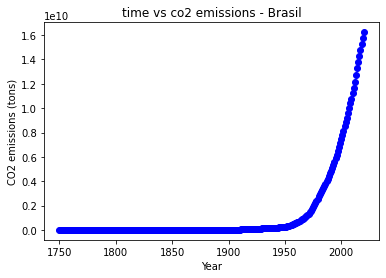

In [0]:
#exploratory plotting - Brasil

fig1=plt.figure()
plt.plot(df1_BR['Year'],df1_BR['CO2 emission (Tons)'],'bo')
plt.xlabel('Year')
plt.ylabel('CO2 emissions (tons)')
plt.title('time vs co2 emissions - Brasil')

plt.savefig('timevsco2')

A partir desse gráfico podemos observar que o boom da emissão de CO2 aconteceu Pós 1950. Para melhor entender como se deu a evolução nos anos pós 1950s, o bloco de código abaixo cria um segundo dataset para o Brasil filtrando os dados e retornando apenas os dados posterior esse data.

Após isso, plotamos um segundo gráfico como o de cima.

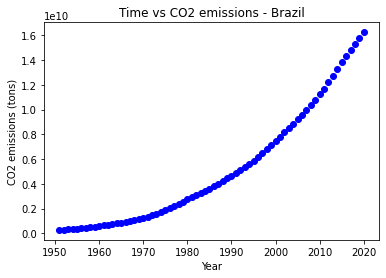

In [0]:
# Filtrar os dados para o Brasil e anos maiores que 1950
df2_BR = DatasetVM[(DatasetVM['Country'] == 'Brazil') & (DatasetVM['Year'] > 1950)]

# Plotar o gráfico
fig1 = plt.figure()
plt.plot(df2_BR['Year'], df2_BR['CO2 emission (Tons)'], 'bo')
plt.xlabel('Year')
plt.ylabel('CO2 emissions (tons)')
plt.title('Time vs CO2 emissions - Brazil')

# Salvar o gráfico como um arquivo
plt.savefig('time_vs_co2.png')

# Exibir o gráfico
plt.show()

### Processo de industrialização Nacional

Para entender como se deu a evolução da emissão de CO2 no país é primordial entender como se deu o nosso processo de industrialização.
De forma resumida, podemos separar a industrialização do Brasil em três fases:

1 - 1930 -1955 - A primeira fase da industrialização foi caracterizada pela “substituição de importações”, quando o governo incentivou a produção local de bens anteriormente importados. Durante essa fase, a emissão de CO2 começou a aumentar à medida que novas indústrias iam se instalando no país, em especial aquelas de bens de consumo duráveis e semi-duráveis. 

2 - 1956 - 1980 - “Milagre Econômico” - Esse período foi caracterizado por uma rápida expansão industrial e urbana. Com isso, houve um aumento significativo das emissões de CO2, em especial na década de 1970, quando iniciaram os investimentos  em indústrias pesadas, como siderurgia e petroquímica. 

3 - 1980 - atualmente - A terceira fase da industrialização brasileira foi conturbada por desafios econômicos, mas foi caracterizada pela abertura econômica e globalização. Desde os anos 1980, as emissões de CO2 continuam a crescer, refletindo o aumento da produção industrial e o crescimento da frota de veículos. A década de 2000, em particular, mostra um aumento acentuado nas emissões devido à expansão industrial e ao aumento do consumo de energia.


A partir do gráfico que mostra a evolução da emissão de CO2 a partir de 1950, podemos observar que a curva de crescimento das emissões de CO2 no Brasil reflete diretamente o processo de industrialização e urbanização do país. Autores como Celso Furtado, Maria da Conceição Tavares e Werner Baer fornecem insights sobre os fatores econômicos e políticos que impulsionaram essa industrialização, correlacionando diretamente com o aumento das emissões de CO2. O gráfico, portanto, não apenas ilustra a evolução das emissões, mas também serve como um indicador das mudanças estruturais na economia brasileira ao longo das décadas.


## 5.2 - Caso US, Uk e China 

O código abaixo cria um dataset que tem como objetivo relacionar a evolução de emissão de CO2 entre os Estados Unidos, UK e China, com o ojetivo de entender a mudança de liderança no ranking de países mais emissores de CO2.

In [0]:
#criando um Dataset completo com os países ditos

df_top3=DatasetVM[(DatasetVM['Country']=='United States')|
                  (DatasetVM['Country']=='China')|
                  (DatasetVM['Country']=='United Kingdom')]

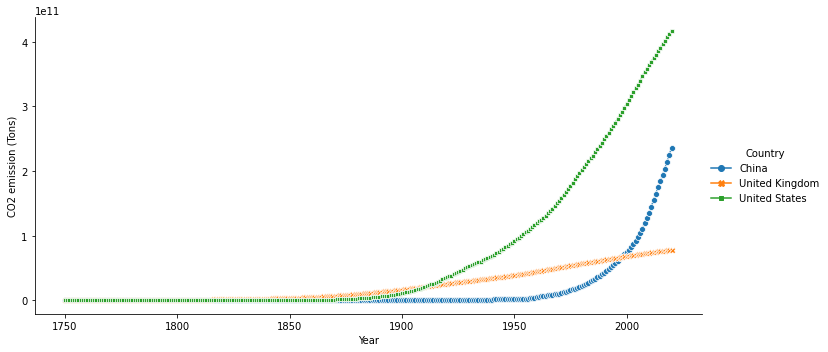

In [0]:
ax=sns.relplot(x="Year", y="CO2 emission (Tons)",
            data=df_top3, kind="line",
            hue="Country", style="Country",
            markers=True, dashes=False,height=5, aspect=2)

A partir desse gráfico, podemos observar que UK liderou o ranking até o início do século XX, quando foi ultrapassado pelos USA. O bloco de código abaixo cria uma nova visualização usando os dados a partir de 1850.

In [0]:
# Filtrando o dataset para os países mencionados e anos a partir de 1850
df1_top3 = DatasetVM[(DatasetVM['Country'].isin(['United States', 'China', 'United Kingdom'])) &
                    (DatasetVM['Year'] >= 1850)]

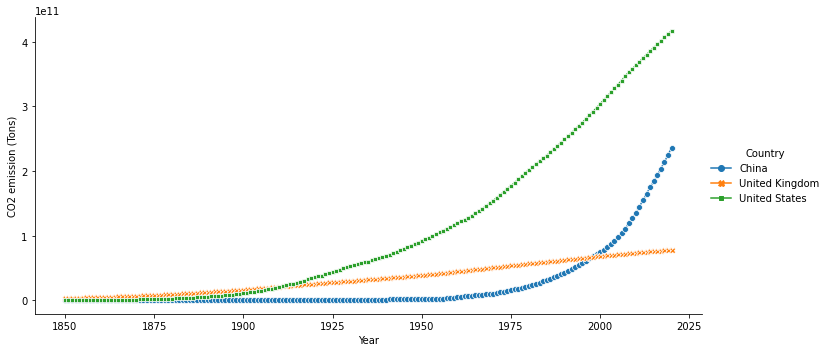

In [0]:
ax=sns.relplot(x="Year", y="CO2 emission (Tons)",
            data=df1_top3, kind="line",
            hue="Country", style="Country",
            markers=True, dashes=False,height=5, aspect=2)

O gráfico acima mostra a evolução das emissões de CO2 desses países ao longo do tempo. Como já vimos em outras literaturas, esse movimento está diretamente ligado à grandes eventos históricos, como as revoluções industriais, as guerras mundiais e a crescente industrialização chinesa. Vamos analisar como esses eventos impactaram as emissões de CO2 de cada um desses países.

Além disso, o gráfico reflete a transição da liderança nas emissões de CO2, que inicialmente pertenciam ao Reino Unido durante a primeira Revolução Industrial, depois passaram para os Estados Unidos durante a Segunda Revolução Industrial e a era pós-guerra, e finalmente para a China nas últimas décadas devido à sua rápida industrialização. Esses padrões são um reflexo direto dos principais eventos históricos e das políticas econômicas que moldaram o desenvolvimento industrial e o consumo de energia em cada um desses países.

Nas próximas etapas trarei detalhes dos momentos históricos de cada país, bem como sua evolução individual. 


### Reino Unido

O bloco de código a seguir filtra o dataset para selecionar apenas os dados referente ao Reino Unido (UK), além disso, cria o gráfico de evolução de CO2 ao longo do tempo. 

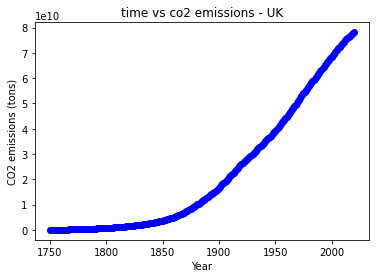

In [0]:
#exploratory plotting - UK

fig1=plt.figure()
plt.plot(df1_BR['Year'],df1_UK['CO2 emission (Tons)'],'bo')
plt.xlabel('Year')
plt.ylabel('CO2 emissions (tons)')
plt.title('time vs co2 emissions - UK')

plt.savefig('timevsco2')

De maneira geral, dois eventos impactam na análise de emissão de CO2 no Reino unido: Revolução industrial e as Guerras Mundiais. 

* Revolução industrial - O UK foi o berço da revolução industrial que começou no final do século XVIII. Durante esse período, houve um aumento significativo na utilização de carvão como fonte de energia para indústrias e transporte, levando a um aumento nas emissões de CO2. O Gráfico mostra um aumento inicial nas emissões de CO2 nesse período, refletindo essa fase.

* Guerras mundiais - As duas guerras mundiais tiveram um impacto significativo na economia britânica, com o aumento da produção industrial para apoiar o esforço de guerra. No entanto, após o fim da segunda guerra mundial, o UK passou por um período de reconstrução e desafios econômicos, o que limitou o crescimento adicional nas emissões.  



### USA

Agora, vamos entender como se deu a evolução do nível de CO2 emitido pelos Estados Unidos ao longo dos anos. Para isso, o código abaixo ilustra a evolução do nível de CO2 emitido por ano em toneladas ao longo dos anos.

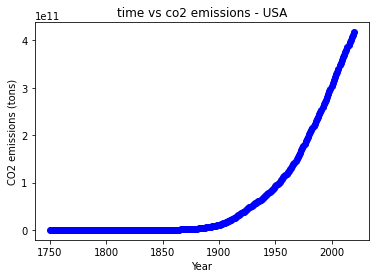

In [0]:
#exploratory plotting - USA

fig1=plt.figure()
plt.plot(df1_US['Year'],df1_US['CO2 emission (Tons)'],'bo')
plt.xlabel('Year')
plt.ylabel('CO2 emissions (tons)')
plt.title('time vs co2 emissions - USA')

plt.savefig('timevsco2')

Da mesma forma como feito para o Brasil, vamos construir um segundo Dataset que irá filtrar os dados para os anos maiores que 1900s. Com isso, o próximo gráfico dará um zoom nessa análise.

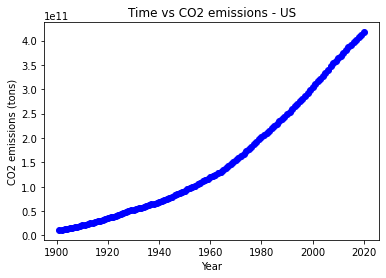

In [0]:
# Filtrar os dados para o USA e anos maiores que 1950
df2_US = DatasetVM[(DatasetVM['Country'] == 'United States') & (DatasetVM['Year'] > 1900)]

# Plotar o gráfico
fig1 = plt.figure()
plt.plot(df2_US['Year'], df2_US['CO2 emission (Tons)'], 'bo')
plt.xlabel('Year')
plt.ylabel('CO2 emissions (tons)')
plt.title('Time vs CO2 emissions - US')

# Salvar o gráfico como um arquivo
plt.savefig('time_vs_co2US.png')

# Exibir o gráfico
plt.show()

Assim como o UK, o rápido crescimento nas emissões de CO2 podem ser explicados por eventos históricos.

* Segunda Revolução industrial - Foi na segunda revolução industrial que se deu início a ascensão dos Estados Unidos como potência Mundial. Em especial, a partir da expansão das indústrias siderúrgicas, ferroviária e automobilística.  O gráfico mostra um aumento significativo nas emissões de CO2 dos Estados Unidos a partir do final do século XIX e acelerando no século XX.

* Pós segunda Guerra Mundial - O período pós-guerra nos EUA foi marcado por um rápido crescimento econômico e um aumento na produção industrial e no consumo de energia. Além disso, também foi conhecida como a era do automóvel, que contribuiu significativamente para as emissões de CO2.

### China 

Por fim, vamos analisar os dados de emissão de CO2 com os dados filtrados para a China ao longo dos anos. Para isso, o código abaixo ilustra a evolução do nível de CO2 emitido por ano em toneladas ao longo dos anos.

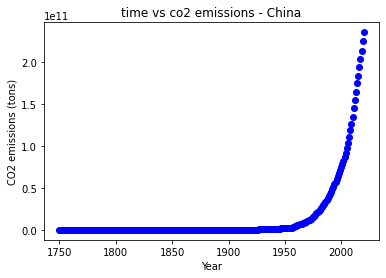

In [0]:
#exploratory plotting - China

fig1=plt.figure()
plt.plot(df1_CH['Year'],df1_CH['CO2 emission (Tons)'],'bo')
plt.xlabel('Year')
plt.ylabel('CO2 emissions (tons)')
plt.title('time vs co2 emissions - China')

plt.savefig('timevsco2')

Assim como o Brasil, a China mantinha a emissão de CO2 em níveis moderados até o fim da década de 1950, quando apresentou um crescimento acelerado. O código abaixo também faz um corte nos dados no tempo e cria um gráfico com as informações após o ano 1950.

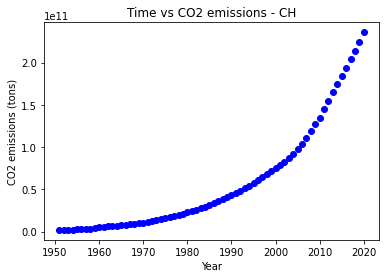

In [0]:
# Filtrar os dados para China e anos maiores que 1950
df2_CH = DatasetVM[(DatasetVM['Country'] == 'China') & (DatasetVM['Year'] > 1950)]

# Plotar o gráfico
fig1 = plt.figure()
plt.plot(df2_CH['Year'], df2_CH['CO2 emission (Tons)'], 'bo')
plt.xlabel('Year')
plt.ylabel('CO2 emissions (tons)')
plt.title('Time vs CO2 emissions - CH')

# Salvar o gráfico como um arquivo
plt.savefig('time_vs_co2CH.png')

# Exibir o gráfico
plt.show()

Para a China, o rápido crescimento do país pode explicar o aumento do nível de CO2 ao longo dos anos. 
A partir da década de 1980, sob a liderança de Deng Xiaoping, a China começou a implementar reformas econômicas que abriram o país ao mercado global e incentivaram a industrialização rápida.

O gráfico mostra um aumento exponencial nas emissões de CO2 da China a partir da década de 1990, refletindo a rápida industrialização e urbanização do país. A China tornou-se a maior emissora de CO2 do mundo, superando os EUA no início do século XXI.

# 6 - Conclusão

Em resumo, os dados mostram que existe uma grande relação entre o nível de emissão de CO2 e evolução do processo histórico de industrialização em alguns países.
O Reino Unido foi o pioneiro na industrialização, mas suas emissões estabilizaram e começaram a declinar à medida que a economia se diversificou e as políticas ambientais foram implementadas com sucesso naquela região. Já os Estados Unidos
Passaram por grandes aumentos nas emissões durante o século XX, especialmente no pós-guerra, mantendo altos níveis de emissão até recentemente. Além disso, a China
Apresenta a mais rápida e recente escalada nas emissões de CO2, diretamente ligada à sua política de industrialização e crescimento econômico acelerado nas últimas décadas.
Sendo assim, Utilizando uma base de dados abrangente, meu objetivo foi entender melhor como grandes eventos históricos, como as revoluções industriais e a rápida industrialização chinesa, influenciaram os níveis globais de CO2, como exposto acima. No entanto, ainda fica a pergunta a ser respondida: o que ainda falta para gente levar esse assunto a sério?


